In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_df = pd.read_csv("./twitter_training.csv")
val_df = pd.read_csv("./twitter_validation.csv")

In [ ]:
train_df.drop(columns=['2401', 'Borderlands'], inplace=True)

train_df.rename(columns={
    "Positive": "Sentiment",
    train_df.columns[-1]: "text"
}, inplace=True)

train_df.columns


Index(['Sentiment', 'text'], dtype='object')

In [ ]:
train_df['Sentiment'].value_counts()

Sentiment
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

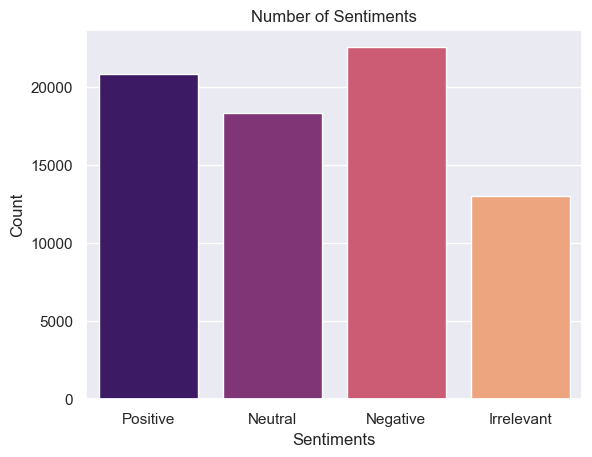

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')
sns.countplot(data = train_df, x='Sentiment', hue='Sentiment', palette='magma')
plt.title('Number of Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.show()

In [ ]:
train_df['label'] = train_df['Sentiment'].replace({
    'Positive' : 3,
    'Negative' : 2,
    'Irrelevant' : 1,
    'Neutral' : 0
})

train_df.drop(columns=['Sentiment'], inplace = True)

C:\Users\mayan\AppData\Local\Temp\ipykernel_3596\342415535.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['label'] = train_df['Sentiment'].replace({


In [ ]:
train_df.head()

,text,label
0,I am coming to the borders and I will kill you...,3
1,im getting on borderlands and i will kill you ...,3
2,im coming on borderlands and i will murder you...,3
3,im getting on borderlands 2 and i will murder ...,3
4,im getting into borderlands and i can murder y...,3


In [ ]:
val_df.drop(columns=['3364', 'Facebook'], inplace=True)
val_df.rename(columns = {
    'Irrelevant' : 'Sentiment',
    val_df.columns[-1] : 'text'
}, inplace=True)

val_df['label'] = val_df['Sentiment'].replace({
    'Positive' : 3,
    'Negative' : 2,
    'Irrelevant' : 1,
    'Neutral' : 0
})

val_df.drop(columns=['Sentiment'], inplace=True)

C:\Users\mayan\AppData\Local\Temp\ipykernel_3596\3331837678.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_df['label'] = val_df['Sentiment'].replace({


In [ ]:
val_df.head()

,text,label
0,BBC News - Amazon boss Jeff Bezos rejects clai...,0
1,@Microsoft Why do I pay for WORD when it funct...,2
2,"CSGO matchmaking is so full of closet hacking,...",2
3,Now the President is slapping Americans in the...,0
4,Hi @EAHelp I’ve had Madeleine McCann in my cel...,2


In [ ]:
train_df["text"] = train_df["text"].astype(str)
val_df["text"] = val_df["text"].astype(str)

### Model TIME!!

In [ ]:
from sklearn.model_selection import train_test_split as tts

train_df, test_df = tts(train_df, test_size=0.2, random_state=42)

In [ ]:
size=4

In [ ]:
from transformers import BertTokenizerFast, TFBertForSequenceClassification, AdamWeightDecay
import tensorflow as tf

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Fix: Convert to list explicitly
train_encodings = tokenizer(train_df["text"].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_df["text"].tolist(), truncation=True, padding=True)


# Convert to tf.data.Dataset
train_df = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"]
    },
    list(train_df["label"])
)).batch(size)

val_df = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": val_encodings["input_ids"],
        "attention_mask": val_encodings["attention_mask"]
    },
    list(val_df["label"])
)).batch(size)

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Load the model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

# Use AdamWeightDecay optimizer
optimizer = AdamWeightDecay(learning_rate=3e-5, weight_decay_rate=0.001)

# Loss function
loss_fn = SparseCategoricalCrossentropy(from_logits=True)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True)

In [ ]:
model.fit(train_df,
          batch_size=size,
          validation_data=val_df,
          epochs=3,
          callbacks=[early])